In [ ]:
 import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRollOld',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRollOld',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:11<00:00, 17.03it/s]


In [ ]:
print(len(lrv_test))

200


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 57217287 (218.27 MB)
Trainable params: 56925895 (217.16 MB)
Non-trainable params: 291392 (1.11 MB)
__________________________________________________________________________________________________


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseVgg16(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.7055

136/136 [==============================] - 309s 2s/step - loss: 0.5585 - accuracy: 0.7055 - val_loss: 0.3666 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8719

136/136 [==============================] - 199s 1s/step - loss: 0.3377 - accuracy: 0.8719 - val_loss: 0.1677 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8899

136/136 [==============================] - 200s 1s/step - loss: 0.2890 - accuracy: 0.8899 - val_loss: 0.1409 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.8986

136/136 [==============================] - 199s 1s/step - loss: 0.2612 - accuracy: 0.8986 - val_loss: 0.1398 - val_accuracy: 0.9634 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9030

136/136 [==============================] - 200s 1s/step - loss: 0.2393 - accuracy: 0.9030 - val_loss: 0.1653 - val_accuracy: 0.9506 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9032

136/136 [==============================] - 200s 1s/step - loss: 0.2167 - accuracy: 0.9032 - val_loss: 0.1133 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9092

136/136 [==============================] - 200s 1s/step - loss: 0.2009 - accuracy: 0.9092 - val_loss: 0.1002 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9178

136/136 [==============================] - 200s 1s/step - loss: 0.1796 - accuracy: 0.9178 - val_loss: 0.0913 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9190

136/136 [==============================] - 199s 1s/step - loss: 0.1686 - accuracy: 0.9190 - val_loss: 0.0710 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9204

136/136 [==============================] - 200s 1s/step - loss: 0.1519 - accuracy: 0.9204 - val_loss: 0.0614 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9206

136/136 [==============================] - 200s 1s/step - loss: 0.1408 - accuracy: 0.9206 - val_loss: 0.0808 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9259

136/136 [==============================] - 199s 1s/step - loss: 0.1308 - accuracy: 0.9259 - val_loss: 0.0565 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9281

136/136 [==============================] - 193s 1s/step - loss: 0.1209 - accuracy: 0.9281 - val_loss: 0.0460 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9252

136/136 [==============================] - 200s 1s/step - loss: 0.1137 - accuracy: 0.9252 - val_loss: 0.0525 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9243

136/136 [==============================] - 200s 1s/step - loss: 0.1065 - accuracy: 0.9243 - val_loss: 0.0489 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9318

136/136 [==============================] - 201s 1s/step - loss: 0.0942 - accuracy: 0.9318 - val_loss: 0.0340 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9332

136/136 [==============================] - 200s 1s/step - loss: 0.0893 - accuracy: 0.9332 - val_loss: 0.0364 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9375

136/136 [==============================] - 199s 1s/step - loss: 0.0822 - accuracy: 0.9375 - val_loss: 0.0287 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9371

136/136 [==============================] - 199s 1s/step - loss: 0.0824 - accuracy: 0.9371 - val_loss: 0.0248 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9350

136/136 [==============================] - 199s 1s/step - loss: 0.0760 - accuracy: 0.9350 - val_loss: 0.0263 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9286

136/136 [==============================] - 199s 1s/step - loss: 0.0756 - accuracy: 0.9286 - val_loss: 0.0456 - val_accuracy: 0.9396 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9442

136/136 [==============================] - 191s 1s/step - loss: 0.0635 - accuracy: 0.9442 - val_loss: 0.0484 - val_accuracy: 0.9506 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9481

136/136 [==============================] - 191s 1s/step - loss: 0.0618 - accuracy: 0.9481 - val_loss: 0.0416 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9462

136/136 [==============================] - 200s 1s/step - loss: 0.0603 - accuracy: 0.9462 - val_loss: 0.0346 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9490

136/136 [==============================] - 191s 1s/step - loss: 0.0577 - accuracy: 0.9490 - val_loss: 0.0426 - val_accuracy: 0.9625 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9430

136/136 [==============================] - 199s 1s/step - loss: 0.0578 - accuracy: 0.9430 - val_loss: 0.0201 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9412

136/136 [==============================] - 202s 1s/step - loss: 0.0570 - accuracy: 0.9412 - val_loss: 0.0377 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9410

136/136 [==============================] - 193s 1s/step - loss: 0.0574 - accuracy: 0.9410 - val_loss: 0.0178 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9494

136/136 [==============================] - 191s 1s/step - loss: 0.0505 - accuracy: 0.9494 - val_loss: 0.0302 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9407

136/136 [==============================] - 199s 1s/step - loss: 0.0576 - accuracy: 0.9407 - val_loss: 0.0197 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9458

136/136 [==============================] - 191s 1s/step - loss: 0.0507 - accuracy: 0.9458 - val_loss: 0.0184 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9451

136/136 [==============================] - 193s 1s/step - loss: 0.0504 - accuracy: 0.9451 - val_loss: 0.0211 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9542

136/136 [==============================] - 200s 1s/step - loss: 0.0443 - accuracy: 0.9542 - val_loss: 0.0184 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9451

136/136 [==============================] - 190s 1s/step - loss: 0.0461 - accuracy: 0.9451 - val_loss: 0.0225 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9499

136/136 [==============================] - 199s 1s/step - loss: 0.0457 - accuracy: 0.9499 - val_loss: 0.0238 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9522

136/136 [==============================] - 199s 1s/step - loss: 0.0419 - accuracy: 0.9522 - val_loss: 0.0147 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9515

136/136 [==============================] - 193s 1s/step - loss: 0.0416 - accuracy: 0.9515 - val_loss: 0.0262 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9595

136/136 [==============================] - 199s 1s/step - loss: 0.0377 - accuracy: 0.9595 - val_loss: 0.0182 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9513

136/136 [==============================] - 199s 1s/step - loss: 0.0430 - accuracy: 0.9513 - val_loss: 0.0366 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9471

136/136 [==============================] - 200s 1s/step - loss: 0.0430 - accuracy: 0.9471 - val_loss: 0.0217 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9538

136/136 [==============================] - 199s 1s/step - loss: 0.0388 - accuracy: 0.9538 - val_loss: 0.0157 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9494

136/136 [==============================] - 199s 1s/step - loss: 0.0422 - accuracy: 0.9494 - val_loss: 0.0316 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9568

136/136 [==============================] - 199s 1s/step - loss: 0.0391 - accuracy: 0.9568 - val_loss: 0.0224 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9538

136/136 [==============================] - 199s 1s/step - loss: 0.0385 - accuracy: 0.9538 - val_loss: 0.0169 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9586

136/136 [==============================] - 200s 1s/step - loss: 0.0344 - accuracy: 0.9586 - val_loss: 0.0297 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9526

136/136 [==============================] - 200s 1s/step - loss: 0.0399 - accuracy: 0.9526 - val_loss: 0.0158 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9556

136/136 [==============================] - 198s 1s/step - loss: 0.0351 - accuracy: 0.9556 - val_loss: 0.0260 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9490

136/136 [==============================] - 199s 1s/step - loss: 0.0391 - accuracy: 0.9490 - val_loss: 0.0192 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9609

136/136 [==============================] - 191s 1s/step - loss: 0.0330 - accuracy: 0.9609 - val_loss: 0.0133 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9577

136/136 [==============================] - 198s 1s/step - loss: 0.0344 - accuracy: 0.9577 - val_loss: 0.0136 - val_accuracy: 0.9890 - lr: 1.0000e-04


47/47 [==============================] - 36s 643ms/step
Confusion matrix, without normalization
[[204   0   0   2   0   0   0]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  1   0   0 204   0   0   0]
 [  0   0   0   0 202   0   4]
 [  0   0   0   0   0 200   0]
 [  0   0   0   0   2   0 198]]


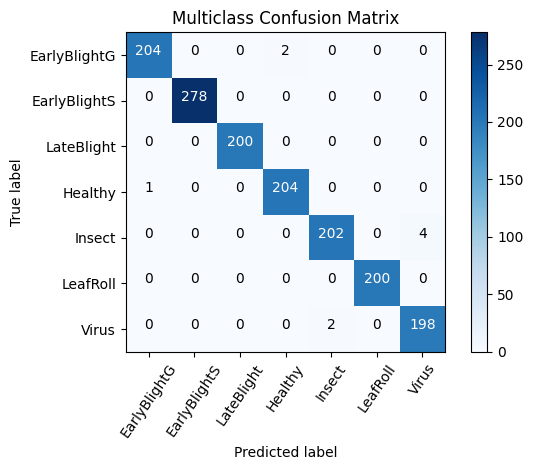

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

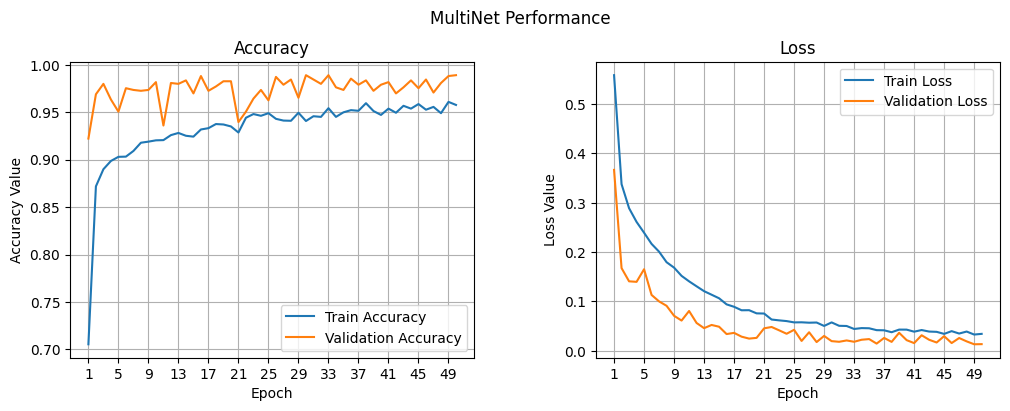

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 17s 357ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.99      0.99       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       1.00      1.00      1.00       200
            Healthy       0.99      1.00      0.99       205
             Insect       0.99      0.98      0.99       206
           LeafRoll       1.00      1.00      1.00       200
              Virus       0.98      0.99      0.99       200

           accuracy                           0.99      1495
          macro avg       0.99      0.99      0.99      1495
       weighted avg       0.99      0.99      0.99      1495



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 17s 360ms/step
MultiNet(ResNet50,DenseNet201,VGG16)
Accuracy: 0.9939799331103679
F1 Score: 0.9939797383098375
precision: 0.9939957629702608
recall: 0.9939799331103679
MSE: 0.03411371237458194
MAE: 0.014046822742474917


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 17s 358ms/step


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc


0.37297297297297294

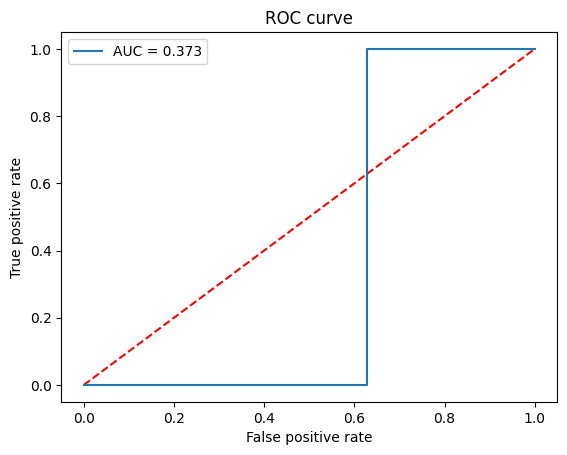

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
